In [5]:
%load_ext autoreload
%autoreload 2

# Load Dependencies
import matplotlib.pyplot as plt

import torch

import pyciemss
from pyciemss.PetriNetODE.interfaces import setup_model, reset_model, intervene, sample, calibrate, optimize, load_petri_model

from pyciemss.utils import get_tspan

import warnings
warnings.filterwarnings('ignore')

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [6]:
# Plotting Utilities

def setup_ax(ax=None):

    if not ax:
        fig = plt.figure(facecolor='w', figsize=(9, 9))
        ax = fig.add_subplot(111, axisbelow=True)

    ax.set_xlabel('Time /days')
    ax.set_ylabel('Infected (1000s)')
    return ax

def plot_predictive(prediction, tspan, tmin=None, ax=None, alpha=0.2, color="black", **kwargs):
    vars = ["I_obs"]
    
    I_low = torch.quantile(prediction["I_obs"], 0.05, dim=0).detach().numpy()
    I_up = torch.quantile(prediction["I_obs"], 0.95, dim=0).detach().numpy()

    if tmin:
        indeces = tspan >= tmin
    else:
        indeces = torch.ones_like(tspan).bool()

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)
    
    ax.fill_between(tspan[indeces], I_low[indeces], I_up[indeces], alpha=alpha, color=color, **kwargs)

    legend = ax.legend()
    legend.get_frame().set_alpha(0.5)

    return ax

def plot_trajectory(data, tspan,  ax=None, color='black', alpha=0.5, lw=0, marker='.', label=None, ):
    # Plot the data on three separate curves for S(t), I(t) and R(t)

    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ax.plot(tspan, data["I_obs"].squeeze().detach().numpy(), color, alpha=alpha, lw=lw, marker=marker, label=label)
    
    return ax

def plot_intervention_line(t, ax=None):
    if not ax:
        fig = plt.figure(facecolor='w')
        ax = fig.add_subplot(111, facecolor='#dddddd', axisbelow=True)

    ylim = ax.get_ylim()

    ax.vlines(t, min(ylim), max(ylim), color="grey", ls='-')

    return ax

In [42]:
# Setup Parameters

full_tspan = get_tspan(1, 89, 89) #bad idea

num_samples = 100

# Total population, N.
N = 100000.0
# Initial number of infected and recovered individuals, I0 and R0.
V0, I0, Iv0, R0 = 0., 81.0, 0., 0. #may want to revisit this choice, consider setting I0 to 1
# Everyone else, S0, is susceptible to infection initially.
S0 = N - I0 - Iv0 - V0 - R0

# 18 - 24 year olds
plot_I_obs = dict(I_obs=torch.tensor([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])) #these numbers make no sense
I_obs = [(float(i+1), dict(I_obs=obs/N)) for i, obs in enumerate([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])]

observed_tspan = get_tspan(1, len(I_obs), len(I_obs)) #also bad

# named_initial_state = {
#     "S": torch.as_tensor(S0),
#     "V": torch.as_tensor(V0),
#     "I": torch.as_tensor(I0),
#     "I_v": torch.as_tensor(Iv0),
#     "R": torch.as_tensor(R0),
# }

# named_final_state = {
#     "S": torch.as_tensor(S0),
#     "V": torch.as_tensor(V0),
#     "I": I_obs[-1],
#     "I_v": torch.as_tensor(Iv0),
#     "R": torch.as_tensor(R0),
# }
I_obs

[(1.0, {'I_obs': 0.0008147}),
 (2.0, {'I_obs': 0.000843}),
 (3.0, {'I_obs': 0.0008644}),
 (4.0, {'I_obs': 0.0008966}),
 (5.0, {'I_obs': 0.0009331999999999999}),
 (6.0, {'I_obs': 0.000941}),
 (7.0, {'I_obs': 0.0009631})]

# Probabilistic Forecasting - Ignoring Historical Data

import json #this doesn't work??
  
petri_net_ode_model = load_petri_model('../../test/models/SVIIvR.json')
petri_net_ode_model

from pyciemss.PetriNetODE.models import MIRA_SVIIvR
petri_net_ode_model = MIRA_SVIIvR.from_mira('../../test/models/SVIIvR.json')

In [52]:
from pyciemss.PetriNetODE.models import MIRA_I_obs_with_scaled_Gaussian_noise
petri_net_ode_model = MIRA_I_obs_with_scaled_Gaussian_noise.from_mira('../../test/models/SVIIvR.json')
petri_net_ode_model.total_population = N
petri_net_ode_model.data_reliability = 4.0
petri_net_ode_model

MIRA_I_obs_with_scaled_Gaussian_noise(
	a_beta = Uniform(low: 0.18000000715255737, high: 0.2199999988079071),
	V_betaV = Uniform(low: 0.03375000134110451, high: 0.04125000163912773),
	u_nu = Uniform(low: 0.0044999998062849045, high: 0.005499999970197678),
	a_gamma = Uniform(low: 0.1574999988079071, high: 0.19249999523162842),
	V_gammaV = Uniform(low: 0.22499999403953552, high: 0.2750000059604645),
	total_population = 100000.0,
	data_reliability = 4.0
)

from pyciemss.PetriNetODE.base import SVIIvRPetriNetODESystem
petri_net_ode_model = SVIIvRPetriNetODESystem.from_mira('../../test/models/SVIIvR.json')

In [53]:
initialized_petri_net_ode_model = setup_model(petri_net_ode_model, start_time=0.0, start_state=dict(S=S0, V=V0, I=I0, I_v=Iv0, R=R0))
#this is giving the wrong documentation string

## Q: "What likely future outcomes does our model imply?"

In [54]:
single_prior =sample(initialized_petri_net_ode_model, timepoints=full_tspan, num_samples=1)
single_prior['I_obs'] = single_prior['I_sol'] + single_prior['I_v_sol']

In [55]:
prior_prediction =sample(initialized_petri_net_ode_model, timepoints=full_tspan, num_samples=100)
prior_prediction['I_obs'] = prior_prediction['I_sol'] + prior_prediction['I_v_sol']

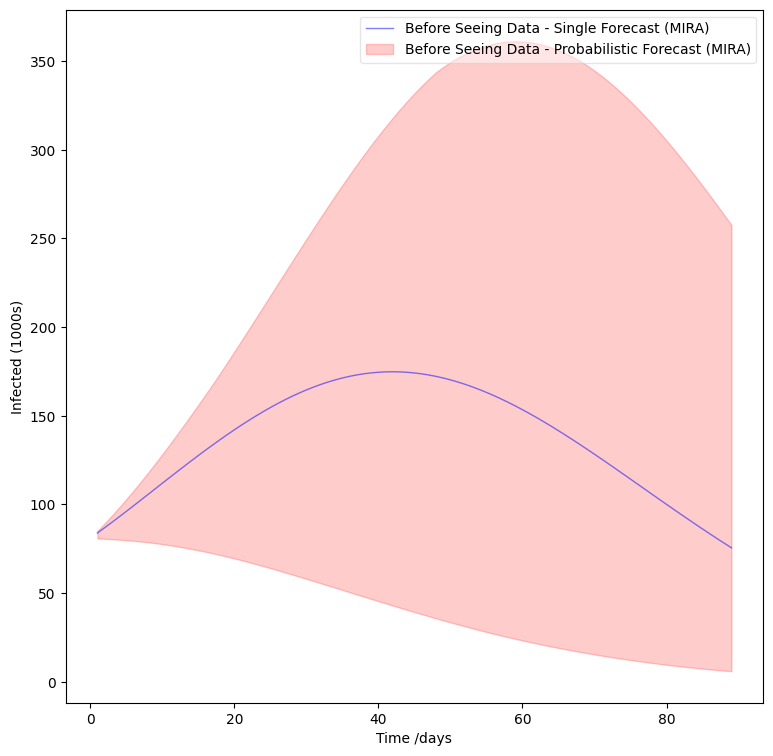

In [56]:
#ax = plot_trajectory(solutions['single_hand_ode_model']['I'], full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast (manual)")
#ax = plot_predictive(solutions['hand_ode_model']['I'], full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast (manual)", color="red", alpha=0.5)
ax = plot_trajectory(single_prior, full_tspan, ax=setup_ax(), color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast (MIRA)")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast (MIRA)", color="red", alpha=0.2)
#ax.set_ylim(0, 105)

In [9]:
plotting_solution['I_v_sol']

tensor([[4.2929e-07, 1.6036e-06, 3.3822e-06,  ..., 8.8570e-05, 8.5582e-05,
         8.2631e-05],
        [4.2471e-07, 1.6028e-06, 3.4131e-06,  ..., 1.7682e-04, 1.7227e-04,
         1.6771e-04],
        [3.7952e-07, 1.4494e-06, 3.1231e-06,  ..., 4.5711e-04, 4.5139e-04,
         4.4541e-04],
        ...,
        [3.3848e-07, 1.2839e-06, 2.7478e-06,  ..., 2.6930e-04, 2.6571e-04,
         2.6200e-04],
        [3.4936e-07, 1.3073e-06, 2.7627e-06,  ..., 1.3436e-04, 1.3139e-04,
         1.2839e-04],
        [3.9631e-07, 1.4901e-06, 3.1646e-06,  ..., 1.4645e-04, 1.4266e-04,
         1.3886e-04]])

## Forecasting - Incorporating Historical Data

In [57]:
data = [(float(i+1), dict(I_obs=obs)) for i, obs in enumerate([81.47, 84.3, 86.44, 89.66, 93.32, 94.1, 96.31])]

calibrated_parameters = calibrate(initialized_petri_net_ode_model, data=data, verbose=True)



iteration 0: loss = 38.08036780357361
iteration 25: loss = 22.470009088516235
iteration 50: loss = 20.23197340965271
iteration 75: loss = 13.987988710403442
iteration 100: loss = 17.407994031906128
iteration 125: loss = 17.13727569580078
iteration 150: loss = 18.247246980667114
iteration 175: loss = 17.07262349128723
iteration 200: loss = 16.53005814552307
iteration 225: loss = 18.38573908805847
iteration 250: loss = 16.36239218711853
iteration 275: loss = 18.021178483963013
iteration 300: loss = 15.74334168434143
iteration 325: loss = 15.45341944694519
iteration 350: loss = 15.557509660720825
iteration 375: loss = 15.71082615852356
iteration 400: loss = 16.758116006851196
iteration 425: loss = 15.844966650009155
iteration 450: loss = 15.490229845046997
iteration 475: loss = 17.03946328163147
iteration 500: loss = 15.299294710159302
iteration 525: loss = 17.278907537460327
iteration 550: loss = 15.629812955856323
iteration 575: loss = 14.670703649520874
iteration 600: loss = 15.5661051

In [58]:
new_tspan = get_tspan(len(I_obs), 89, 89-len(I_obs))
posterior_prediction = sample(initialized_petri_net_ode_model,  inferred_parameters =calibrated_parameters, timepoints=full_tspan, num_samples=100)
posterior_prediction['I_obs'] = posterior_prediction['I_sol'] + posterior_prediction['I_v_sol']
single_posterior = sample(initialized_petri_net_ode_model,  inferred_parameters =calibrated_parameters, timepoints=full_tspan, num_samples=1)
single_posterior['I_obs'] = single_posterior['I_sol'] + single_posterior['I_v_sol']


## Q: "What future outcomes are likely given the data we've seen?"

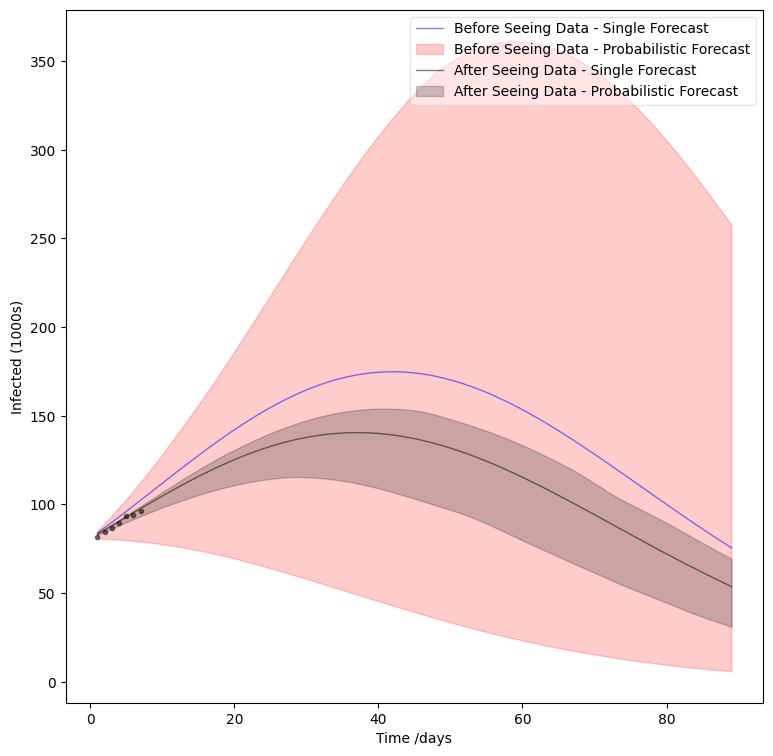

In [60]:
ax = plot_trajectory(plot_I_obs, get_tspan(1,len(I_obs), len(I_obs)), ax=setup_ax())
ax = plot_trajectory(single_prior, full_tspan, ax=ax, color="blue", marker='', lw=1., label="Before Seeing Data - Single Forecast")
ax = plot_predictive(prior_prediction, full_tspan, ax=ax, label="Before Seeing Data - Probabilistic Forecast", color="red")
ax = plot_trajectory(single_posterior, full_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
ax = plot_predictive(posterior_prediction, full_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast")

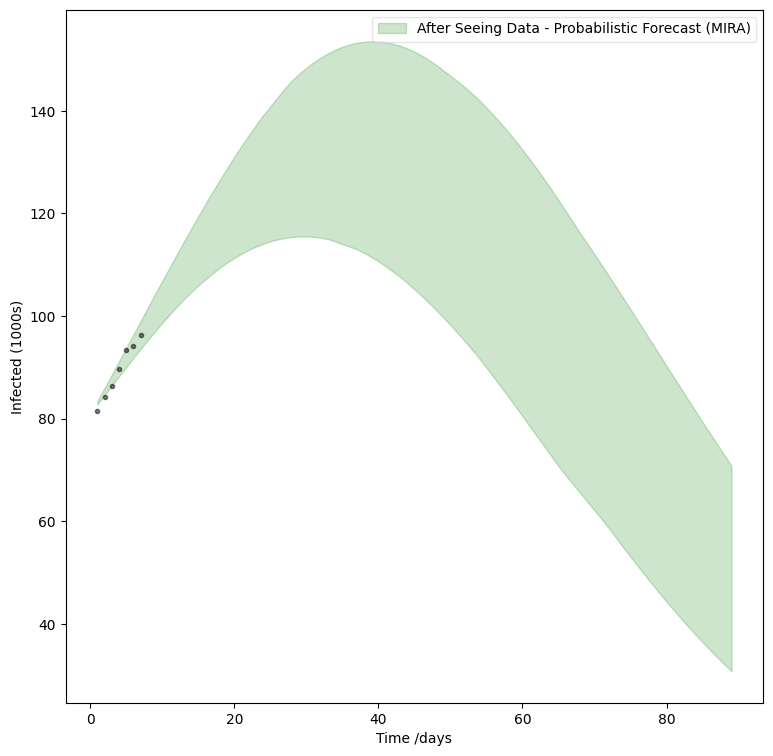

In [35]:
ax = plot_trajectory(plot_I_obs, get_tspan(1,len(I_obs), len(I_obs)), ax=setup_ax())

#ax = plot_trajectory(data, full_tspan, ax=ax)
# ax = plot_trajectory(map_prediction, new_tspan, ax=ax, marker='', lw=1., label="After Seeing Data - Single Forecast")
#ax = plot_predictive(hand_posterior_prediction, new_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast (manual)", color="blue")
ax = plot_predictive(posterior_prediction, full_tspan, ax=ax, label="After Seeing Data - Probabilistic Forecast (MIRA)", color="green")

# Probabilistic Forecasting - Exploring Possible Interventions



## Q: "What would happen if we set the vaccination rate parameter, $\nu$?"


In [61]:
# note that we cannot intervene at a previously existing timepoint, or odeint will complain.
rate_parameter_intervention = [(7.5, "nu", 0.01)]
# intervened_parameter_model = do(plotting_ode_model, rate_parameter_intervention)
intervened_parameter_model = intervene(initialized_petri_net_ode_model, rate_parameter_intervention)
# intervened_parameter_prediction = Predictive(intervened_parameter_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
intervened_parameter_prediction = sample(intervened_parameter_model, full_tspan, num_samples, calibrated_parameters)
intervened_parameter_prediction ['I_obs'] = intervened_parameter_prediction ['I_sol'] + intervened_parameter_prediction ['I_v_sol']


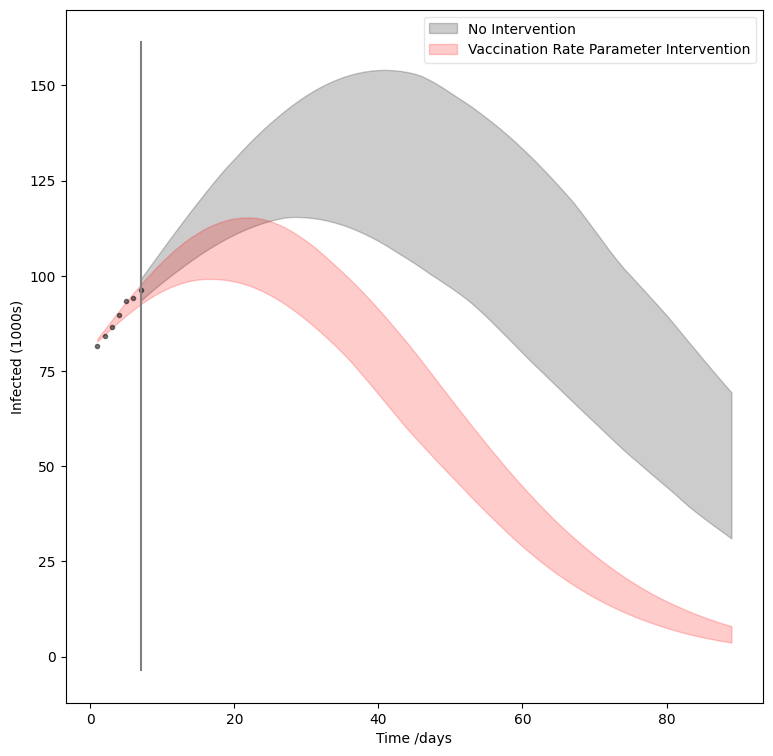

In [62]:

ax = setup_ax()
ax = plot_trajectory(plot_I_obs, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, full_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, full_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We can't change the rate parameter directly. Bring me another policy!"
## Q: "What would happen if we set the vaccination rate to a constant 500 people per day?"

In [28]:
pyro.set_rng_seed(0)

flux_intervention = constant_intervention_builder("SV_flux", torch.tensor([500.]), full_tspan)
# intervened_flux_model = do(ode_model, flux_intervention)
plotting_intervened_flux_model = intervene(plotting_ode_model, flux_intervention)
# intervened_flux_prediction = Predictive(plotting_intervened_flux, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
rate_intervention_prediction = sample(plotting_intervened_flux_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)

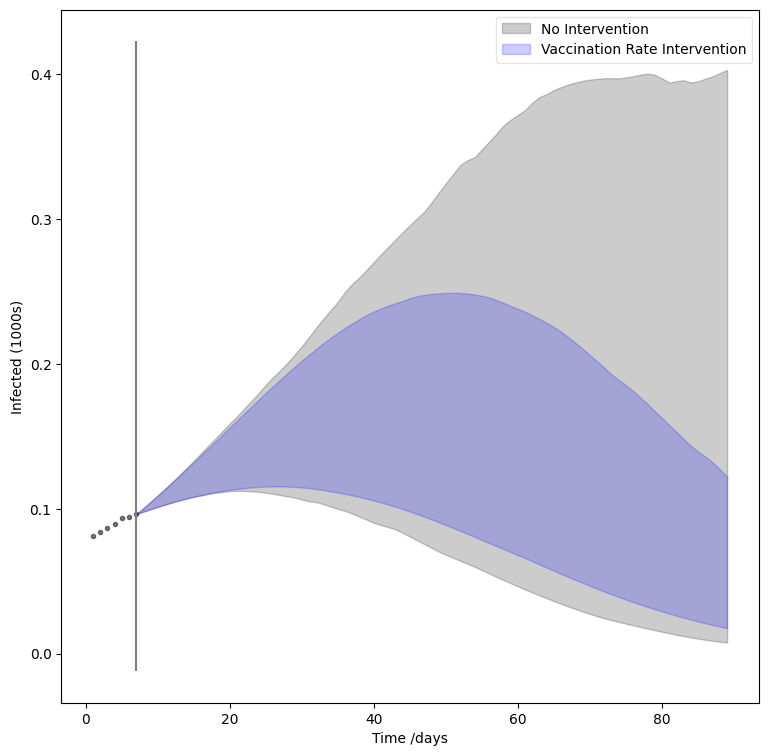

In [16]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, ax=ax, color='blue', label="Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)

## Governor: "We have a lot more vaccines than that, but they aren't available yet!"
## Q: "What would happen if we set the vaccination rate to 500 people per day for the first month, then 750, then 1000?"


In [18]:
pyro.set_rng_seed(0)

def ramping_rate_up_intervention_function(t):
    month = torch.floor(t / 30.).int()
    return torch.tensor([500.0, 750.0, 1000.])[month]

ramping_rate_up_intervention = time_dependent_intervention_builder("SV_flux", ramping_rate_up_intervention_function, new_tspan)
# ramping_rate_up_intervention_model = do(plotting_ode_model, ramping_rate_up_intervention)
plotting_ramping_rate_up_intervention_model = intervene(plotting_ode_model, ramping_rate_up_intervention)
# ramping_rate_up_intervention_prediction = Predictive(plotting_ramping_rate_up_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
ramping_intervention_prediction = sample(plotting_ramping_rate_up_intervention_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


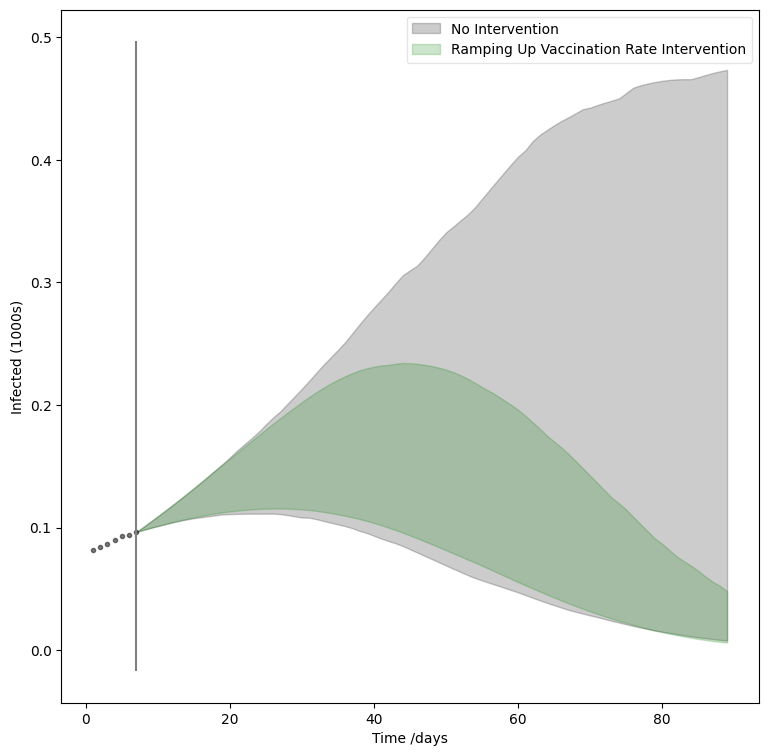

In [19]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, label="No Intervention")
ax = plot_predictive(ramping_intervention_prediction, new_tspan, ax=ax, color='green', label="Ramping Up Vaccination Rate Intervention")
ax = plot_intervention_line(7., ax=ax)


## Governor: "We can't force people to take a vaccine. Let's run a marketing campaign to encourage vaccination!"
## Q: "What would happen if the marketing campaign convinces 500 **more** people per day to get vaccinated than without it?"


In [22]:
pyro.set_rng_seed(0)

def vaccination_encouragement_intervention_function(SV_flux):
    return SV_flux + torch.tensor([500.])

vaccination_encouragement_intervention = state_dependent_intervention_builder("SV_flux", vaccination_encouragement_intervention_function, new_tspan)
# plotting_vaccination_encouragement_intervention_model = do(ode_model, vaccination_encouragement_intervention)
plotting_vaccination_encouragement_intervention_model = intervene(plotting_ode_model, vaccination_encouragement_intervention)
# vaccination_encouragement_intervention_prediction = Predictive(vaccination_encouragement_intervention_model, guide=guide, num_samples=num_samples)(final_observed_state, new_tspan)
vaccination_encouragement_intervention_prediction = sample(plotting_vaccination_encouragement_intervention_model, num_samples, final_observed_state, new_tspan, inferred_parameters=inferred_parameters)


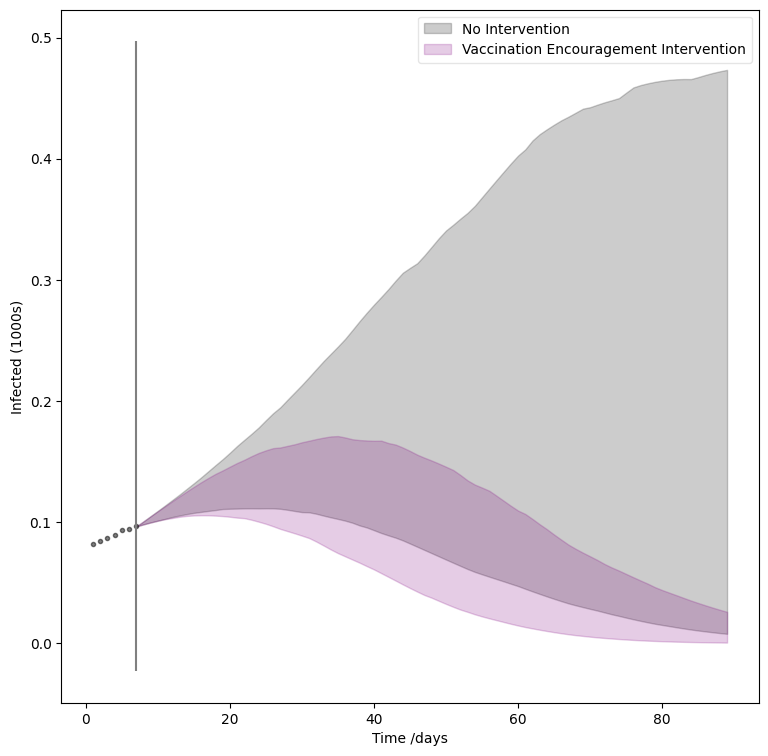

In [23]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, ax=ax, color='black', label="No Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, ax=ax, color='purple', label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)


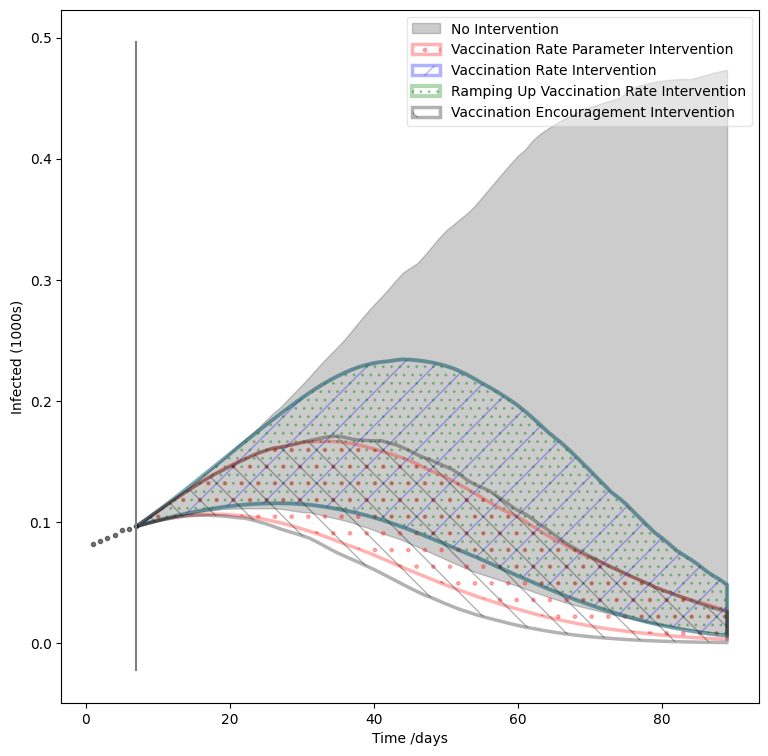

In [24]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, color='black', ax=ax, label="No Intervention")
ax = plot_predictive(intervened_parameter_prediction, new_tspan, hatch='.', edgecolor="red", linewidth=2.5, facecolor="none", ax=ax, alpha=0.3, label="Vaccination Rate Parameter Intervention")
ax = plot_predictive(rate_intervention_prediction, new_tspan, hatch='/', ax=ax, alpha=0.3, linewidth=2.5, edgecolor='blue', facecolor="none", label="Vaccination Rate Intervention")
ax = plot_predictive(ramping_intervention_prediction, new_tspan, hatch='..', linewidth=3, ax=ax, alpha=0.3, edgecolor='green', facecolor="none", label="Ramping Up Vaccination Rate Intervention")
ax = plot_predictive(vaccination_encouragement_intervention_prediction, new_tspan, hatch="\\", linewidth=2.5, ax=ax, alpha=0.3, edgecolor='black', facecolor="none", label="Vaccination Encouragement Intervention")
ax = plot_intervention_line(7., ax=ax)


## Governor: "Let's only market to young people!"
## Q: "What would happen if the marketing campaign convinces 500 more people age 18-24 per day to get vaccinated than without it?"


In [25]:

pyro.set_rng_seed(0)

stratified_intervention = state_dependent_intervention_builder("SV_flux_18-24", vaccination_encouragement_intervention_function, new_tspan)
# stratified_intervention_model = do(ode_model, stratified_intervention)
stratified_intervention_model = intervene(ode_model, stratified_intervention)


In [24]:

import sys
ipython = get_ipython()

def hide_traceback(exc_tuple=None, filename=None, tb_offset=None,
                   exception_only=False, running_compiled_code=False):
    etype, value, tb = sys.exc_info()
    value.__cause__ = None  # suppress chained exceptions
    return ipython._showtraceback(etype, value, ipython.InteractiveTB.get_exception_only(etype, value))

ipython.showtraceback = hide_traceback

raise ValueError("The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24").with_traceback(None) from None

ValueError: The Intervention Variable SV_flux_18-24 is not defined and can not be intervened on. To fix this error, revise the model to include SV_flux_18-24

# Risk-based optimization under uncertainty
## Q: "What is the minimal vaccination policy that results in less than 150 infected individuals after 90 days?"

### Problem Formulation
* **Quantity of interest**: 7-day average of total infections after 90 days
    $$M(\mathbf{u}, \theta) = \frac{1}{7}\sum_{i=0}^6 I(t=90-i;\mathbf{u},\theta)+I_\text{V}(t=90-i;\mathbf{u},\theta)$$

* **Control**: $\mathbf{u}\in \mathcal{U} \subseteq \mathbb{R}^{n_u}$
    * Vaccination rate parameter: $u=\nu$
    * Scheduled intervention changing SV_flux over each month: $\mathbf{u} \in \mathbb{R}^3$
    * Other practical policies as interventions



* **Risk-based optimization under uncertainty problem formulation**
    * Objective Function - Minimize the vaccination rate.
    * Constraint - Risk of infections exceeding the prescribed threshold of 10, $\mathcal{R}( M(\mathbf{u}, \theta))$, is below the acceptable risk threshold, $\mathcal{R}_\text{threshold}$.

\begin{equation} 
\begin{split} 
\mathbf{u}^*= \underset{\mathbf{u}\in\mathcal{U}}{\arg\min}\ & \lVert \mathbf{u} \rVert_1 \\ \text{s.t.}\ & \mathcal{R}( M(\mathbf{u}, \theta)) \le \mathcal{R}_\text{threshold} 
\end{split} 
\end{equation}

## Comparing risk measures

![table_risk.png](figures/table_risk.png)

#### Adavantages of using alpha-superquantile
* Considers magnitude of infections exceeding the threshold:
    * Overcome limitations of hard thresholding
    * Desirable data-informed conservativeness
* Preserves properties of underlying quantities of interest, such as convexity

In [25]:
import os
import time
import pickle

import sys
sys.path.append("../")

import numpy as np
from scipy import stats
from matplotlib import ticker

from pyciemss.ODE.models import SVIIvR
from pyciemss.ODE.interventions import constant_intervention_builder

from pyciemss.risk.risk_measures import alpha_quantile, alpha_superquantile
from pyciemss.risk.ouu import computeRisk
from pyciemss.risk.qoi import nday_rolling_average

# Plotting helpers
def sideaxis(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    return

def sideaxishist(ax):
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(False)
    # For y-axis
    ax.yaxis.set_major_locator(ticker.NullLocator())
    ax.tick_params(axis='x', labelsize=12)  # change fontsize for x-axis tick labels
    # ax.xaxis.major.formatter._useMathText = True
    return


co = ['#377eb8', '#ff7f00', '#984ea3', '#ffd92f', '#a65628']
rlabel = ['Q_alpha-based OUU', 'barQ_alpha-based OUU']

## Exploring the difference between Quantiles and Super-Quantiles

In [26]:
torch.manual_seed(1)

POLICY = np.array([100.])
N_SAMPLES = 1000

RISK = computeRisk(model=ode_model,
                 intervention_fun=lambda x: constant_intervention_builder("SV_flux", torch.from_numpy(x), new_tspan),
                 qoi=lambda y: nday_rolling_average(y, contexts=["I_obs"]),
                 risk_measure=alpha_superquantile,
                 num_samples=N_SAMPLES,
                 model_state=final_observed_state,
                 tspan=new_tspan,
                 guide=guide
                )

start_time = time.time()
sq_dataCube = RISK.propagate_uncertainty(POLICY)
end_time = time.time()
forward_time = end_time - start_time
time_per_eval = forward_time / N_SAMPLES
print(f"Forward UQ took {forward_time:.2f} seconds total ({forward_time/N_SAMPLES:.2e} seconds per model evaluation).")
sq_qoi = RISK.qoi(sq_dataCube)
sq_sv = RISK.risk_measure(sq_qoi)

RISK.risk_measure = alpha_quantile
q_sv = RISK(POLICY)

Forward UQ took 40.57 seconds total (4.06e-02 seconds per model evaluation).


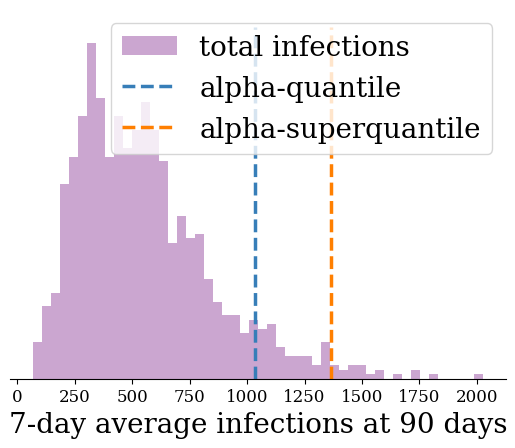

In [27]:
bins_hist = 50
fig1 = plt.figure()
plt.rc('text', usetex=False)
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(sq_qoi, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections')
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(q_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-quantile', color=co[0])
cax.vlines(sq_sv, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()

## Risk-based optimization under uncertainty with intervention on vaccination rate parameter $\nu$
**NOTE:** This is a demonstration of the interface, optimization is not run to convergence nor are enough samples generated to accurately estimate the risk, so take the results with a grain of salt.

In [28]:
from pyciemss.risk.ouu import RandomDisplacementBounds, computeRisk, solveOUU
from pyciemss.risk.qoi import nday_rolling_average
from pyciemss.risk.risk_measures import alpha_superquantile, alpha_quantile
import scipy

# Define problem specifics.
RISK_BOUND = 250.
X_MIN = 0.
X_MAX = 0.95

N_SAMPLES = int(5e2)
MAXITER = 10
TOL = 1e-5

RISK_ALPHA = 0.9

# Control action / intervention.
INIT_ITERATE = 0.75
INTERVENTION = lambda x: constant_intervention_builder("nu", x, new_tspan)

# Objective function.
OBJFUN = lambda x: x  # minimize the scalar value itself.

# Define the risk measure.
VAX_RISK = computeRisk(
                        model=noisy_ode_model,
                        intervention_fun=INTERVENTION,
                        qoi=lambda y: nday_rolling_average(y, contexts=["I_obs"]),
                        model_state=final_observed_state,
                        tspan=new_tspan,
                        risk_measure=lambda z: alpha_superquantile(z, alpha=RISK_ALPHA),
                        num_samples=N_SAMPLES,
                        guide=guide,
                        )

# Define problem constraints.
CONSTRAINTS = (
                # risk constraint
                {'type': 'ineq', 'fun': lambda x: RISK_BOUND - VAX_RISK(x)},

                # bounds on control
                # NOTE: perhaps use scipy.optimize.LinearConstraint in the future
                {'type': 'ineq', 'fun': lambda x: x - X_MIN},
                {'type': 'ineq', 'fun': lambda x: X_MAX - x}
               )

In [29]:
# Go do the dang thing.
print("Performing risk-based optimization under uncertainty ...")
print(f"Estimated wait time {time_per_eval*N_SAMPLES*MAXITER:.0f} seconds.")
sq_result = solveOUU(
                     x0=INIT_ITERATE,
                     objfun=OBJFUN,
                     constraints=CONSTRAINTS,
                     optimizer_algorithm="COBYLA",
                     tol=TOL,
                     options={
                         "disp": False,
                         "maxiter": MAXITER
                             },
                    ).solve()
print(f"Optimizer finished. Optimal Vaccination rate is:\t{sq_result.x[0]:.4}")
est_risk = VAX_RISK(sq_result.x[0])
print(f"Estimated risk was:\t{est_risk:.2f}")

Performing risk-based optimization under uncertainty ...
Estimated wait time 203 seconds.
Optimizer finished. Optimal Vaccination rate is:	1.75
Estimated risk was:	496.06


## Assess the effect of the control policy.

In [30]:
intervened_prediction = VAX_RISK.propagate_uncertainty(POLICY)
qois = VAX_RISK.qoi(intervened_prediction)

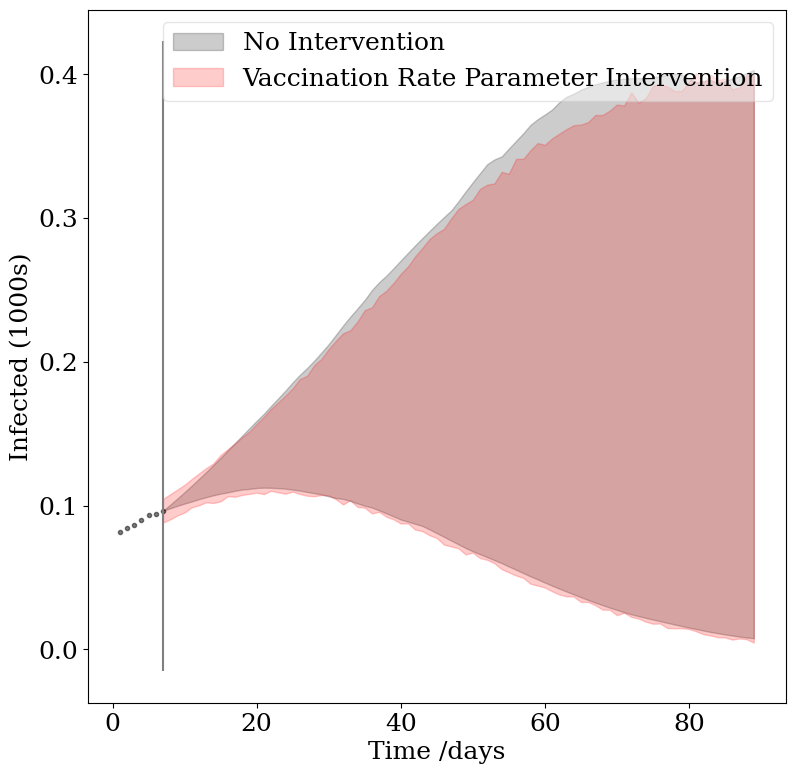

In [31]:

ax = setup_ax()
ax = plot_trajectory(data, observed_tspan, ax=ax)
ax = plot_predictive(posterior_prediction, new_tspan, tmin=7, ax=ax, label="No Intervention")
ax = plot_predictive(intervened_prediction, new_tspan, ax=ax, color='red', label="Vaccination Rate Parameter Intervention")
ax = plot_intervention_line(7., ax=ax)


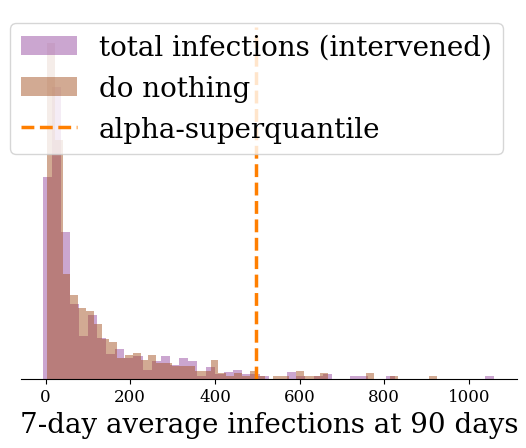

In [32]:
bins_hist = 50
fig1 = plt.figure()
# plt.rc('text')
plt.rc('font', family='serif', size=18.)
cax = plt.gca()
sideaxishist(cax)
cax.hist(qois, color=co[2], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='total infections (intervened)', density=True)
cax.hist(VAX_RISK.qoi(posterior_prediction), color=co[4], bins=bins_hist, histtype='stepfilled', alpha=0.5, label='do nothing', density=True)
miny = min(cax.get_ylim())
maxy = max(cax.get_ylim())
cax.vlines(est_risk, miny, maxy, linestyle='--', linewidth=2.5, label='alpha-superquantile', color=co[1])
cax.set_xlabel('7-day average infections at 90 days', size=20)
cax.legend(loc='upper right', prop={'size': 20})
plt.show()